## hw10

### 1，先训练随机森林模型，判断变量的重要性。根据前N个最重要的变量，重新构建神经网络模型（必做）

In [1]:
# %load DNN.py
import pandas as pd
import datetime
import collections
import numpy as np
import numbers
import random
import sys
import pickle
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators import SKCompat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from importlib import reload
from matplotlib import pyplot as plt
import operator
# -*- coding: utf-8 -*-

C:\Users\Ian\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def Missingrate_Column(df, col):
    '''
    :param df:
    :param col:
    :return:
    '''
    missing_records = df[col].map(lambda x: int(x!=x))
    return missing_records.mean()


def Makeup_Missing(df,col, makeup_value):
    '''
    :param df:
    :param col:
    :return:
    '''
    raw_values = list(df[col])
    missing_position = [i for i in range(len(raw_values)) if raw_values[i] != raw_values[i]]
    for i in missing_position:
        raw_values[i] = makeup_value
    return raw_values


def Outlier_Effect(df,col,target,percentiles=[1,99]):
    '''
    :param df:
    :param col:
    :param target:
    :return:
    '''
    p1, p3 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    d = p3 - p1
    upper, lower = p3 + 1.5 * d, p1 - 1.5 * d
    lower_sample, middle_sample, upper_sample = df[df[col]<lower], df[(df[col]>=lower)&(df[col]<=upper)], df[df[col]>upper]
    lower_fraud, middle_fraud, upper_fraud = lower_sample[target].mean(), middle_sample[target].mean(), upper_sample[target].mean()
    lower_logodds, upper_logodds = np.log(lower_fraud/middle_fraud),np.log(upper_fraud/middle_fraud)
    return [lower_logodds, upper_logodds]

def Zero_Score_Normalization(series):
    '''
    :param df:
    :param col:
    :param target:
    :return:
    '''
    p1, p3 = np.percentile(series, 25), np.percentile(series, 75)
    d = p3 - p1
    if d == 0:
        return -1
    upper, lower = p3 + 1.5 * d, p1 - 1.5 * d
    new_col = series.map(lambda x: min(max(x, lower),upper))
    mu,sigma = new_col.mean(), np.sqrt(new_col.var())
    new_var = new_col.map(lambda x: (x-mu)/sigma)
    return {'new_var':new_var,'lower':lower,'upper':upper,'mu':mu, 'sigma':sigma}



def Avg_Calc(numerator, denominator):
    if denominator == 0:
        return 0
    else:
        return numerator/denominator


def Detect_Outlier(x):
    p1,p3 = np.percentile(x,25), np.percentile(x,75)
    d = p3-p1
    upper, lower = p3+1.5*d, p1 - 1.5*d
    x2 = x.map(lambda x: min(max(x, lower), upper))
    return x2

def ROC_AUC(df, score, target, plot=True):
    df2 = df.copy()
    s = list(set(df2[score]))
    s.sort()
    tpr_list = [0]
    fpr_list = [0]
    for k in s:
        df2['label_temp'] = df[score].map(lambda x: int(x >= k))
        TP = df2[(df2.label_temp==1) & (df2[target]==1)].shape[0]
        FN = df2[(df2.label_temp == 1) & (df2[target] == 0)].shape[0]
        FP = df2[(df2.label_temp == 0) & (df2[target] == 1)].shape[0]
        TN = df2[(df2.label_temp == 0) & (df2[target] == 0)].shape[0]
        try:
            TPR = TP / (TP + FN)
        except:
            TPR =0
        try:
            FPR = FP / (FP + TN)
        except:
            FPR = 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    tpr_list.append(1)
    fpr_list.append(1)
    ROC_df = pd.DataFrame({'tpr': tpr_list, 'fpr': fpr_list})
    ROC_df = ROC_df.sort_values(by='tpr')
    ROC_df = ROC_df.drop_duplicates()
    auc = 0
    ROC_mat = np.mat(ROC_df)
    for i in range(1, ROC_mat.shape[0]):
        auc = auc + (ROC_mat[i, 1] + ROC_mat[i - 1, 1]) * (ROC_mat[i, 0] - ROC_mat[i - 1, 0]) * 0.5
    if plot:
        plt.plot(ROC_df['fpr'], ROC_df['tpr'])
        plt.plot([0, 1], [0, 1])
        plt.title("AUC={}%".format(int(auc * 100)))
    return auc


def KS(df, score, target, plot = True):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或者概率
    :param target: 目标变量
    :return: KS值
    :return: KS值
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all = all.sort_values(by=score, ascending = False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    KS_list = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    KS = max(KS_list)
    if plot:
        plt.plot(list(all.index), all['badCumRate'])
        plt.plot(list(all.index), all['goodCumRate'])
        plt.title('KS ={}%'.format(int(KS*100)))
    return KS

In [16]:
#######################
####  1，读取数据  #####
#######################
folderOfData = '../05/'
data = pd.read_csv(folderOfData + 'anti_fraud_data.csv', header = 0)

#为了减少训练时间，减少数据集
data = data.iloc[:10000,:]
train_data, test_data = train_test_split(data, test_size=0.3)
y_train, y_test = train_data['flag'], test_data['flag']


area1_danger is a constant
is_area5_equal_area3 is a constant
is_area5_equal_area4 is a constant
is_area5_equal_area6 is a constant
is_area1_equal_area2 is a constant
is_area7_equal_area5 is a constant
is_area2_equal_area5 is a constant
area10_danger is a constant
is_area1_equal_area11 is a constant
is_area8_equal_area5 is a constant
is_area9_equal_area5 is a constant
goods_type is a constant
30d_AcctPerDevice is a constant
30d_AcctPerIP is a constant
1d_Max_pay_amount is a constant
12h_Min_pay_amount is a constant
1d_Min_pay_amount is a constant


C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


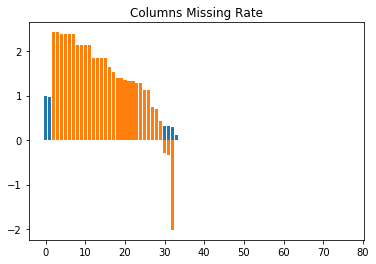

In [4]:
del train_data['ID']
##############################
####  2，缺失值分析与补缺  #####
##############################
#先检查是否有常数型字段

all_columns = list(train_data.columns)
all_columns.remove('flag')

fix_value_check = {col: len(set(train_data[col])) for col in all_columns}
fix_value_vars = [var for var in list(fix_value_check.keys()) if fix_value_check[var] == 1]
for var in fix_value_vars:
    print("{} is a constant".format(var))
    all_columns.remove(var)
    del train_data[var]

#查看每个字段的缺失率
column_missingrate = {col: Missingrate_Column(train_data, col) for col in all_columns}
column_MR_df = pd.DataFrame.from_dict(column_missingrate, orient='index')
column_MR_df.columns = ['missing_rate']
column_MR_df_sorted = column_MR_df.sort_values(by='missing_rate', ascending=False)
plt.bar(x=range(column_MR_df_sorted.shape[0]), height=column_MR_df_sorted.missing_rate)
plt.title('Columns Missing Rate')
#由于变量ip_desc_danger在训练集中全部缺失，故将其删去。
all_columns.remove('ip_desc_danger')
del train_data['ip_desc_danger']
column_MR_df_sorted = column_MR_df_sorted.drop(index=['ip_desc_danger'])
columns_with_missing = column_MR_df_sorted[column_MR_df_sorted.missing_rate > 0].index

#查看缺失值与非缺失值对欺诈的影响
check_missingrate = {}
for col in columns_with_missing:
    temp_df = train_data[[col,'flag']]
    temp_df[col] = temp_df.apply(lambda x: int(x[col] != x[col]),axis=1)
    a = temp_df['flag'].groupby(temp_df[col]).mean()
    check_missingrate[col] = [a.ix[0], a.ix[1]]
check_missingrate_df = pd.DataFrame.from_dict(check_missingrate, orient='index')
check_missingrate_df['log_odds'] = check_missingrate_df.apply(lambda x: np.log(x[1] / x[0]), axis = 1)
check_missingrate_df_sorted = check_missingrate_df.sort_values(by='log_odds', ascending=False)
check_missingrate_df_sorted.columns = ['fraud_rate_nonmissing', 'fraud_rate_missing','log_odds']
plt.bar(x = range(check_missingrate_df_sorted.shape[0]), height = check_missingrate_df_sorted.log_odds)


categorical_cols = []
numerical_cols = []
#区分类别型变量和数值型变量
for col in all_columns:
    temp_df = train_data[train_data[col].notna()][col]
    temp_df = list(set(temp_df))
    if len(temp_df)<=10 or isinstance(temp_df[0],str):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

### 对类别型变量进行哑变量编码，并删除原始变量 ###
dummy_map = {}
dummy_columns = []
for raw_col in categorical_cols:
    dummies = pd.get_dummies(train_data.loc[:, raw_col], prefix=raw_col)
    col_onehot = pd.concat([train_data[raw_col], dummies], axis=1)
    col_onehot = col_onehot.drop_duplicates()
    train_data = pd.concat([train_data, dummies], axis=1)
    del train_data[raw_col]
    dummy_map[raw_col] = col_onehot
    dummy_columns = dummy_columns + list(dummies)


#对于数值型变量，可以将原始变量与表示缺失状态的示性变量交互地使用.此外，由于这些变量都是非负数，对于缺失，可以用0来填补
for col in numerical_cols:
    missing_values = train_data[train_data[col].isna()]
    if missing_values.shape[0]>0:
        train_data[col+'_ismissing']  = train_data[col].map(lambda x: int(x!=x))

train_data = train_data.fillna(0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
train_data['age_ismissing']  = train_data['age'].map(lambda x: int(x==0))

In [5]:
train_data.shape

(7000, 170)

In [6]:
features = list(train_data.columns)
features.remove('flag')
X,y = train_data[features], train_data['flag']

### 训练随机森林模型，判断变量的重要性

In [7]:
from sklearn.ensemble import RandomForestClassifier
RFC_2 = RandomForestClassifier(oob_score=True)
RFC_2.fit(X,y)
print(RFC_2.oob_score_)

0.9905714285714285


C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [8]:
from pandas import DataFrame
df = DataFrame({'imp':RFC_2.feature_importances_,'features':features})
df_sorted = df.sort_values(by='imp', ascending=False)
df_sorted.head()

,features,imp
2,paytime_hour,0.060426
3,pay_amount,0.059181
4,Bank_Bind_Hour,0.045697
0,age,0.031741
66,is_area3_equal_area6_0,0.025527


In [10]:
########################################
# Step 3: 构建基于TensorFlow的神经网络模型 #
########################################
X_train = train_data.copy()
X_train = X_train[df_sorted['features'][:20]]
# del X_train['flag']
x_train = np.matrix(X_train)
y_train = np.matrix(train_data['flag']).T



#进一步将训练集拆分成训练集和验证集。在新训练集上进行参数估计，在验证集上决定最优的参数

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train,test_size=0.4,random_state=9)

In [11]:
#Example: select the best number of units in the 1-layer hidden layer
no_hidden_units_selection = {}
feature_columns = [tf.contrib.layers.real_valued_column("", dimension = x_train.shape[1])]
for no_hidden_units in range(50,71,10):
    print("the current choise of hidden units number is {}".format(no_hidden_units))
    clf0 = tf.contrib.learn.DNNClassifier(feature_columns = feature_columns,
                                          hidden_units=[no_hidden_units, no_hidden_units-10,no_hidden_units-20],
                                          n_classes=2,
                                          dropout = 0.5
                                          )
    clf = SKCompat(clf0)
    clf.fit(x_train, y_train, batch_size=256,steps = 100000)
    #monitor the performance of the model using AUC score
    clf_pred_proba = clf._estimator.predict_proba(x_validation)
    pred_proba = [i[1] for i in clf_pred_proba]
    auc_score = roc_auc_score(y_validation.getA(),pred_proba)
    no_hidden_units_selection[no_hidden_units] = auc_score
best_hidden_units = max(no_hidden_units_selection.items(), key=operator.itemgetter(1))[0]   #60
best_hidden_units

the current choise of hidden units number is 50
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E8835EEDD8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoi

INFO:tensorflow:global_step/sec: 363.993
INFO:tensorflow:loss = 30.341766, step = 2500 (0.274 sec)
INFO:tensorflow:global_step/sec: 338.082
INFO:tensorflow:loss = 0.031368043, step = 2600 (0.297 sec)
INFO:tensorflow:global_step/sec: 372.142
INFO:tensorflow:loss = 0.11849504, step = 2700 (0.268 sec)
INFO:tensorflow:global_step/sec: 376.355
INFO:tensorflow:loss = 0.07007466, step = 2800 (0.266 sec)
INFO:tensorflow:global_step/sec: 385.819
INFO:tensorflow:loss = 0.041748516, step = 2900 (0.259 sec)
INFO:tensorflow:global_step/sec: 385.012
INFO:tensorflow:loss = 0.027996272, step = 3000 (0.260 sec)
INFO:tensorflow:global_step/sec: 346.901
INFO:tensorflow:loss = 0.09501718, step = 3100 (0.288 sec)
INFO:tensorflow:global_step/sec: 368.023
INFO:tensorflow:loss = 58.362774, step = 3200 (0.271 sec)
INFO:tensorflow:global_step/sec: 382.856
INFO:tensorflow:loss = 0.068014115, step = 3300 (0.261 sec)
INFO:tensorflow:global_step/sec: 383.592
INFO:tensorflow:loss = 9.939995, step = 3400 (0.261 sec)


INFO:tensorflow:global_step/sec: 389.587
INFO:tensorflow:loss = 0.09666739, step = 10700 (0.257 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.06299726, step = 10800 (0.253 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.013091083, step = 10900 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.09713011, step = 11000 (0.254 sec)
INFO:tensorflow:global_step/sec: 385.818
INFO:tensorflow:loss = 0.013087834, step = 11100 (0.259 sec)
INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 0.0632881, step = 11200 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.02955353, step = 11300 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.653
INFO:tensorflow:loss = 0.09697009, step = 11400 (0.255 sec)
INFO:tensorflow:global_step/sec: 386.567
INFO:tensorflow:loss = 0.012589676, step = 11500 (0.258 sec)
INFO:tensorflow:global_step/sec: 388.069
INFO:tensorflow:loss = 0.012538951, step = 11600

INFO:tensorflow:global_step/sec: 380.664
INFO:tensorflow:loss = 0.08088746, step = 18800 (0.262 sec)
INFO:tensorflow:global_step/sec: 385.074
INFO:tensorflow:loss = 0.01093965, step = 18900 (0.260 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.028384378, step = 19000 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.08082987, step = 19100 (0.252 sec)
INFO:tensorflow:global_step/sec: 388.826
INFO:tensorflow:loss = 0.063319124, step = 19200 (0.258 sec)
INFO:tensorflow:global_step/sec: 388.827
INFO:tensorflow:loss = 0.045996282, step = 19300 (0.257 sec)
INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 0.063682325, step = 19400 (0.255 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.011057098, step = 19500 (0.254 sec)
INFO:tensorflow:global_step/sec: 389.586
INFO:tensorflow:loss = 0.010771028, step = 19600 (0.257 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.080927774, step = 1

INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 0.06400244, step = 26900 (0.255 sec)
INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.09903644, step = 27000 (0.253 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.02800047, step = 27100 (0.254 sec)
INFO:tensorflow:global_step/sec: 383.593
INFO:tensorflow:loss = 0.08102839, step = 27200 (0.260 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.06424876, step = 27300 (0.254 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.081327416, step = 27400 (0.255 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.081162654, step = 27500 (0.253 sec)
INFO:tensorflow:global_step/sec: 385.075
INFO:tensorflow:loss = 0.04584119, step = 27600 (0.260 sec)
INFO:tensorflow:global_step/sec: 398.935
INFO:tensorflow:loss = 0.045902364, step = 27700 (0.251 sec)
INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 0.06359049, step = 27800 

INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.06359253, step = 35000 (0.251 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.045798928, step = 35100 (0.253 sec)
INFO:tensorflow:global_step/sec: 389.484
INFO:tensorflow:loss = 0.028158847, step = 35200 (0.257 sec)
INFO:tensorflow:global_step/sec: 386.565
INFO:tensorflow:loss = 0.04572166, step = 35300 (0.258 sec)
INFO:tensorflow:global_step/sec: 395.756
INFO:tensorflow:loss = 0.045927428, step = 35400 (0.252 sec)
INFO:tensorflow:global_step/sec: 394.986
INFO:tensorflow:loss = 0.14956397, step = 35500 (0.253 sec)
INFO:tensorflow:global_step/sec: 386.567
INFO:tensorflow:loss = 0.06351429, step = 35600 (0.259 sec)
INFO:tensorflow:global_step/sec: 390.349
INFO:tensorflow:loss = 0.028649887, step = 35700 (0.256 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.027879894, step = 35800 (0.252 sec)
INFO:tensorflow:global_step/sec: 395.769
INFO:tensorflow:loss = 0.01021973, step = 3590

INFO:tensorflow:global_step/sec: 358.755
INFO:tensorflow:loss = 0.045751177, step = 43100 (0.331 sec)
INFO:tensorflow:global_step/sec: 261.264
INFO:tensorflow:loss = 0.081480615, step = 43200 (0.331 sec)
INFO:tensorflow:global_step/sec: 385.819
INFO:tensorflow:loss = 0.063607424, step = 43300 (0.258 sec)
INFO:tensorflow:global_step/sec: 391.114
INFO:tensorflow:loss = 0.05387737, step = 43400 (0.256 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.08141055, step = 43500 (0.255 sec)
INFO:tensorflow:global_step/sec: 388.827
INFO:tensorflow:loss = 0.08148147, step = 43600 (0.257 sec)
INFO:tensorflow:global_step/sec: 370.759
INFO:tensorflow:loss = 0.06357017, step = 43700 (0.269 sec)
INFO:tensorflow:global_step/sec: 391.881
INFO:tensorflow:loss = 0.027967338, step = 43800 (0.256 sec)
INFO:tensorflow:global_step/sec: 396.558
INFO:tensorflow:loss = 0.045879405, step = 43900 (0.252 sec)
INFO:tensorflow:global_step/sec: 365.998
INFO:tensorflow:loss = 0.028086245, step = 44

INFO:tensorflow:global_step/sec: 351.796
INFO:tensorflow:loss = 0.06354846, step = 51200 (0.285 sec)
INFO:tensorflow:global_step/sec: 343.911
INFO:tensorflow:loss = 0.06349558, step = 51300 (0.290 sec)
INFO:tensorflow:global_step/sec: 378.498
INFO:tensorflow:loss = 0.11351217, step = 51400 (0.265 sec)
INFO:tensorflow:global_step/sec: 370.743
INFO:tensorflow:loss = 0.093388714, step = 51500 (0.269 sec)
INFO:tensorflow:global_step/sec: 379.939
INFO:tensorflow:loss = 0.06368497, step = 51600 (0.264 sec)
INFO:tensorflow:global_step/sec: 362.011
INFO:tensorflow:loss = 0.04570793, step = 51700 (0.276 sec)
INFO:tensorflow:global_step/sec: 376.355
INFO:tensorflow:loss = 0.140717, step = 51800 (0.266 sec)
INFO:tensorflow:global_step/sec: 330.794
INFO:tensorflow:loss = 0.09790949, step = 51900 (0.304 sec)
INFO:tensorflow:global_step/sec: 311.668
INFO:tensorflow:loss = 0.099222906, step = 52000 (0.322 sec)
INFO:tensorflow:global_step/sec: 361.355
INFO:tensorflow:loss = 0.04580358, step = 52100 (0

INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.099403016, step = 59300 (0.253 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.045898914, step = 59400 (0.255 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.028083831, step = 59500 (0.260 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.045849208, step = 59600 (0.252 sec)
INFO:tensorflow:global_step/sec: 393.429
INFO:tensorflow:loss = 0.063750245, step = 59700 (0.254 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.045936055, step = 59800 (0.255 sec)
INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:loss = 0.06371392, step = 59900 (0.263 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.09938568, step = 60000 (0.251 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.081497, step = 60100 (0.254 sec)
INFO:tensorflow:global_step/sec: 392.653
INFO:tensorflow:loss = 0.11715559, step = 60200

INFO:tensorflow:global_step/sec: 380.664
INFO:tensorflow:loss = 0.081443585, step = 67400 (0.264 sec)
INFO:tensorflow:global_step/sec: 368.651
INFO:tensorflow:loss = 0.045943126, step = 67500 (0.271 sec)
INFO:tensorflow:global_step/sec: 390.348
INFO:tensorflow:loss = 0.08158632, step = 67600 (0.256 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.0815177, step = 67700 (0.254 sec)
INFO:tensorflow:global_step/sec: 390.349
INFO:tensorflow:loss = 0.028158808, step = 67800 (0.256 sec)
INFO:tensorflow:global_step/sec: 371.443
INFO:tensorflow:loss = 0.08163668, step = 67900 (0.269 sec)
INFO:tensorflow:global_step/sec: 394.994
INFO:tensorflow:loss = 0.045961373, step = 68000 (0.253 sec)
INFO:tensorflow:global_step/sec: 398.141
INFO:tensorflow:loss = 0.04591388, step = 68100 (0.251 sec)
INFO:tensorflow:global_step/sec: 394.155
INFO:tensorflow:loss = 0.028195977, step = 68200 (0.254 sec)
INFO:tensorflow:global_step/sec: 383.592
INFO:tensorflow:loss = 0.04586106, step = 6830

INFO:tensorflow:global_step/sec: 395.771
INFO:tensorflow:loss = 0.027980704, step = 75500 (0.253 sec)
INFO:tensorflow:global_step/sec: 382.855
INFO:tensorflow:loss = 0.06373924, step = 75600 (0.261 sec)
INFO:tensorflow:global_step/sec: 395.771
INFO:tensorflow:loss = 0.097881995, step = 75700 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.06888327, step = 75800 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.028030165, step = 75900 (0.252 sec)
INFO:tensorflow:global_step/sec: 382.122
INFO:tensorflow:loss = 0.06378449, step = 76000 (0.262 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.045969263, step = 76100 (0.258 sec)
INFO:tensorflow:global_step/sec: 355.559
INFO:tensorflow:loss = 0.09947339, step = 76200 (0.281 sec)
INFO:tensorflow:global_step/sec: 391.867
INFO:tensorflow:loss = 0.028180562, step = 76300 (0.256 sec)
INFO:tensorflow:global_step/sec: 382.856
INFO:tensorflow:loss = 0.045968436, step = 76

INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.06376799, step = 83600 (0.254 sec)
INFO:tensorflow:global_step/sec: 390.331
INFO:tensorflow:loss = 0.02809905, step = 83700 (0.256 sec)
INFO:tensorflow:global_step/sec: 387.317
INFO:tensorflow:loss = 0.028132318, step = 83800 (0.259 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.028048187, step = 83900 (0.253 sec)
INFO:tensorflow:global_step/sec: 394.207
INFO:tensorflow:loss = 0.010216562, step = 84000 (0.253 sec)
INFO:tensorflow:global_step/sec: 387.316
INFO:tensorflow:loss = 0.06364459, step = 84100 (0.258 sec)
INFO:tensorflow:global_step/sec: 389.961
INFO:tensorflow:loss = 0.0100450665, step = 84200 (0.256 sec)
INFO:tensorflow:global_step/sec: 394.986
INFO:tensorflow:loss = 175.62639, step = 84300 (0.253 sec)
INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.08167811, step = 84400 (0.253 sec)
INFO:tensorflow:global_step/sec: 383.592
INFO:tensorflow:loss = 0.045897137, step = 8450

INFO:tensorflow:global_step/sec: 395.769
INFO:tensorflow:loss = 0.045983195, step = 91700 (0.253 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.09918745, step = 91800 (0.253 sec)
INFO:tensorflow:global_step/sec: 387.317
INFO:tensorflow:loss = 0.063719034, step = 91900 (0.258 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.010256459, step = 92000 (0.259 sec)
INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.08158353, step = 92100 (0.252 sec)
INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.063751526, step = 92200 (0.253 sec)
INFO:tensorflow:global_step/sec: 387.317
INFO:tensorflow:loss = 0.045877106, step = 92300 (0.258 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.063675925, step = 92400 (0.253 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.06363002, step = 92500 (0.252 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.028072102, step = 926

INFO:tensorflow:global_step/sec: 362.015
INFO:tensorflow:loss = 0.04594025, step = 99800 (0.277 sec)
INFO:tensorflow:global_step/sec: 316.616
INFO:tensorflow:loss = 0.01035304, step = 99900 (0.315 sec)
INFO:tensorflow:Saving checkpoints for 100000 into C:\Users\Ian\AppData\Local\Temp\tmpktoypc75\model.ckpt.
INFO:tensorflow:Loss for final step: 0.08160086.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ian\AppData\Local\Temp\tmpktoypc75\model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
the current choise of hidden units number is 60
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config

INFO:tensorflow:global_step/sec: 373.536
INFO:tensorflow:loss = 0.03321299, step = 5400 (0.268 sec)
INFO:tensorflow:global_step/sec: 378.497
INFO:tensorflow:loss = 9.545851, step = 5500 (0.265 sec)
INFO:tensorflow:global_step/sec: 358.756
INFO:tensorflow:loss = 0.032522842, step = 5600 (0.279 sec)
INFO:tensorflow:global_step/sec: 360.702
INFO:tensorflow:loss = 0.04803519, step = 5700 (0.277 sec)
INFO:tensorflow:global_step/sec: 363.33
INFO:tensorflow:loss = 0.032429084, step = 5800 (0.275 sec)
INFO:tensorflow:global_step/sec: 368.022
INFO:tensorflow:loss = 0.016552608, step = 5900 (0.272 sec)
INFO:tensorflow:global_step/sec: 385.818
INFO:tensorflow:loss = 0.054755375, step = 6000 (0.258 sec)
INFO:tensorflow:global_step/sec: 377.781
INFO:tensorflow:loss = 0.015935764, step = 6100 (0.265 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.06353562, step = 6200 (0.258 sec)
INFO:tensorflow:global_step/sec: 379.939
INFO:tensorflow:loss = 0.063955605, step = 6300 (0.263 sec

INFO:tensorflow:global_step/sec: 309.253
INFO:tensorflow:loss = 0.09806451, step = 13600 (0.323 sec)
INFO:tensorflow:global_step/sec: 301.311
INFO:tensorflow:loss = 0.06338504, step = 13700 (0.332 sec)
INFO:tensorflow:global_step/sec: 297.27
INFO:tensorflow:loss = 0.011247478, step = 13800 (0.338 sec)
INFO:tensorflow:global_step/sec: 302.225
INFO:tensorflow:loss = 0.08053346, step = 13900 (0.330 sec)
INFO:tensorflow:global_step/sec: 291.194
INFO:tensorflow:loss = 0.08044601, step = 14000 (0.342 sec)
INFO:tensorflow:global_step/sec: 286.592
INFO:tensorflow:loss = 0.08068213, step = 14100 (0.349 sec)
INFO:tensorflow:global_step/sec: 201.687
INFO:tensorflow:loss = 0.08087651, step = 14200 (0.495 sec)
INFO:tensorflow:global_step/sec: 286.181
INFO:tensorflow:loss = 0.028457217, step = 14300 (0.352 sec)
INFO:tensorflow:global_step/sec: 273.244
INFO:tensorflow:loss = 0.097935915, step = 14400 (0.364 sec)
INFO:tensorflow:global_step/sec: 304.067
INFO:tensorflow:loss = 0.053733986, step = 14500

INFO:tensorflow:global_step/sec: 374.223
INFO:tensorflow:loss = 0.0458453, step = 21700 (0.268 sec)
INFO:tensorflow:global_step/sec: 369.385
INFO:tensorflow:loss = 0.04575245, step = 21800 (0.270 sec)
INFO:tensorflow:global_step/sec: 364.658
INFO:tensorflow:loss = 0.08133355, step = 21900 (0.274 sec)
INFO:tensorflow:global_step/sec: 365.327
INFO:tensorflow:loss = 0.045756176, step = 22000 (0.274 sec)
INFO:tensorflow:global_step/sec: 374.21
INFO:tensorflow:loss = 0.04584203, step = 22100 (0.267 sec)
INFO:tensorflow:global_step/sec: 380.664
INFO:tensorflow:loss = 0.08129508, step = 22200 (0.263 sec)
INFO:tensorflow:global_step/sec: 362.011
INFO:tensorflow:loss = 0.06355244, step = 22300 (0.278 sec)
INFO:tensorflow:global_step/sec: 354.926
INFO:tensorflow:loss = 0.028163075, step = 22400 (0.279 sec)
INFO:tensorflow:global_step/sec: 369.385
INFO:tensorflow:loss = 0.06342298, step = 22500 (0.271 sec)
INFO:tensorflow:global_step/sec: 377.067
INFO:tensorflow:loss = 0.081182584, step = 22600 (

INFO:tensorflow:global_step/sec: 394.205
INFO:tensorflow:loss = 0.0979104, step = 29800 (0.254 sec)
INFO:tensorflow:global_step/sec: 361.355
INFO:tensorflow:loss = 0.028080165, step = 29900 (0.278 sec)
INFO:tensorflow:global_step/sec: 363.993
INFO:tensorflow:loss = 0.06362735, step = 30000 (0.273 sec)
INFO:tensorflow:global_step/sec: 381.393
INFO:tensorflow:loss = 0.046058066, step = 30100 (0.262 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.08135701, step = 30200 (0.257 sec)
INFO:tensorflow:global_step/sec: 354.925
INFO:tensorflow:loss = 0.06370947, step = 30300 (0.282 sec)
INFO:tensorflow:global_step/sec: 391.883
INFO:tensorflow:loss = 0.06366836, step = 30400 (0.255 sec)
INFO:tensorflow:global_step/sec: 398.141
INFO:tensorflow:loss = 0.06371128, step = 30500 (0.251 sec)
INFO:tensorflow:global_step/sec: 361.354
INFO:tensorflow:loss = 0.0815278, step = 30600 (0.277 sec)
INFO:tensorflow:global_step/sec: 382.169
INFO:tensorflow:loss = 0.13479014, step = 30700 (0.

INFO:tensorflow:global_step/sec: 391.885
INFO:tensorflow:loss = 0.23153183, step = 37900 (0.255 sec)
INFO:tensorflow:global_step/sec: 388.824
INFO:tensorflow:loss = 0.04587234, step = 38000 (0.257 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.04595092, step = 38100 (0.252 sec)
INFO:tensorflow:global_step/sec: 395.771
INFO:tensorflow:loss = 0.04591212, step = 38200 (0.253 sec)
INFO:tensorflow:global_step/sec: 395.771
INFO:tensorflow:loss = 0.054151967, step = 38300 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.637
INFO:tensorflow:loss = 0.01034688, step = 38400 (0.255 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.08156627, step = 38500 (0.252 sec)
INFO:tensorflow:global_step/sec: 391.883
INFO:tensorflow:loss = 0.045909964, step = 38600 (0.255 sec)
INFO:tensorflow:global_step/sec: 383.593
INFO:tensorflow:loss = 0.09937468, step = 38700 (0.261 sec)
INFO:tensorflow:global_step/sec: 382.122
INFO:tensorflow:loss = 0.028181436, step = 38800

INFO:tensorflow:global_step/sec: 391.114
INFO:tensorflow:loss = 0.08144836, step = 46000 (0.256 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.06384775, step = 46100 (0.255 sec)
INFO:tensorflow:global_step/sec: 375.647
INFO:tensorflow:loss = 0.045985576, step = 46200 (0.265 sec)
INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:loss = 0.16759653, step = 46300 (0.264 sec)
INFO:tensorflow:global_step/sec: 383.593
INFO:tensorflow:loss = 0.081541345, step = 46400 (0.260 sec)
INFO:tensorflow:global_step/sec: 376.355
INFO:tensorflow:loss = 0.028209455, step = 46500 (0.266 sec)
INFO:tensorflow:global_step/sec: 375.646
INFO:tensorflow:loss = 0.028004766, step = 46600 (0.266 sec)
INFO:tensorflow:global_step/sec: 383.592
INFO:tensorflow:loss = 0.063804954, step = 46700 (0.261 sec)
INFO:tensorflow:global_step/sec: 377.067
INFO:tensorflow:loss = 0.010293633, step = 46800 (0.265 sec)
INFO:tensorflow:global_step/sec: 385.802
INFO:tensorflow:loss = 0.04602899, step = 46

INFO:tensorflow:global_step/sec: 393.429
INFO:tensorflow:loss = 0.09949218, step = 54100 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.08160082, step = 54200 (0.253 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.045976065, step = 54300 (0.258 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.04597838, step = 54400 (0.252 sec)
INFO:tensorflow:global_step/sec: 391.113
INFO:tensorflow:loss = 0.028164241, step = 54500 (0.256 sec)
INFO:tensorflow:global_step/sec: 392.655
INFO:tensorflow:loss = 0.063727245, step = 54600 (0.254 sec)
INFO:tensorflow:global_step/sec: 391.113
INFO:tensorflow:loss = 0.06376927, step = 54700 (0.256 sec)
INFO:tensorflow:global_step/sec: 374.237
INFO:tensorflow:loss = 0.15297967, step = 54800 (0.267 sec)
INFO:tensorflow:global_step/sec: 377.066
INFO:tensorflow:loss = 0.0637299, step = 54900 (0.265 sec)
INFO:tensorflow:global_step/sec: 375.646
INFO:tensorflow:loss = 6.0092974, step = 55000 (0

INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 22.90995, step = 62200 (0.254 sec)
INFO:tensorflow:global_step/sec: 387.317
INFO:tensorflow:loss = 0.099358946, step = 62300 (0.258 sec)
INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.028105542, step = 62400 (0.253 sec)
INFO:tensorflow:global_step/sec: 393.429
INFO:tensorflow:loss = 0.045979224, step = 62500 (0.255 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.063771725, step = 62600 (0.251 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.11731961, step = 62700 (0.252 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.045933556, step = 62800 (0.251 sec)
INFO:tensorflow:global_step/sec: 382.841
INFO:tensorflow:loss = 0.06377086, step = 62900 (0.261 sec)
INFO:tensorflow:global_step/sec: 395.739
INFO:tensorflow:loss = 0.08161011, step = 63000 (0.253 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.028056439, step = 63100 (

INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.028063888, step = 70300 (0.253 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.06381026, step = 70400 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.11719095, step = 70500 (0.252 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.010152749, step = 70600 (0.261 sec)
INFO:tensorflow:global_step/sec: 394.969
INFO:tensorflow:loss = 0.11727671, step = 70700 (0.253 sec)
INFO:tensorflow:global_step/sec: 396.558
INFO:tensorflow:loss = 0.063691474, step = 70800 (0.252 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.099442735, step = 70900 (0.251 sec)
INFO:tensorflow:global_step/sec: 388.056
INFO:tensorflow:loss = 0.045976546, step = 71000 (0.258 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.08156925, step = 71100 (0.251 sec)
INFO:tensorflow:global_step/sec: 392.03
INFO:tensorflow:loss = 0.028095076, step = 71200

INFO:tensorflow:global_step/sec: 389.586
INFO:tensorflow:loss = 0.010271816, step = 78400 (0.257 sec)
INFO:tensorflow:global_step/sec: 395.771
INFO:tensorflow:loss = 0.063814946, step = 78500 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.557
INFO:tensorflow:loss = 0.06385487, step = 78600 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.653
INFO:tensorflow:loss = 0.06385757, step = 78700 (0.254 sec)
INFO:tensorflow:global_step/sec: 391.883
INFO:tensorflow:loss = 0.045954384, step = 78800 (0.255 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.0995584, step = 78900 (0.252 sec)
INFO:tensorflow:global_step/sec: 392.653
INFO:tensorflow:loss = 0.028076407, step = 79000 (0.255 sec)
INFO:tensorflow:global_step/sec: 394.207
INFO:tensorflow:loss = 0.0980822, step = 79100 (0.254 sec)
INFO:tensorflow:global_step/sec: 391.114
INFO:tensorflow:loss = 0.010238378, step = 79200 (0.255 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.028124224, step = 79300 

INFO:tensorflow:global_step/sec: 395.769
INFO:tensorflow:loss = 0.08161107, step = 86500 (0.253 sec)
INFO:tensorflow:global_step/sec: 391.883
INFO:tensorflow:loss = 0.09952905, step = 86600 (0.255 sec)
INFO:tensorflow:global_step/sec: 395.77
INFO:tensorflow:loss = 0.028096663, step = 86700 (0.253 sec)
INFO:tensorflow:global_step/sec: 398.141
INFO:tensorflow:loss = 0.09939914, step = 86800 (0.252 sec)
INFO:tensorflow:global_step/sec: 394.971
INFO:tensorflow:loss = 0.08165925, step = 86900 (0.253 sec)
INFO:tensorflow:global_step/sec: 394.986
INFO:tensorflow:loss = 0.06365566, step = 87000 (0.254 sec)
INFO:tensorflow:global_step/sec: 361.926
INFO:tensorflow:loss = 0.099498525, step = 87100 (0.276 sec)
INFO:tensorflow:global_step/sec: 370.071
INFO:tensorflow:loss = 0.028094186, step = 87200 (0.270 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.028089112, step = 87300 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.653
INFO:tensorflow:loss = 0.028111666, step = 8740

INFO:tensorflow:global_step/sec: 393.429
INFO:tensorflow:loss = 0.06385248, step = 94600 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.986
INFO:tensorflow:loss = 0.028140333, step = 94700 (0.253 sec)
INFO:tensorflow:global_step/sec: 394.987
INFO:tensorflow:loss = 0.09952706, step = 94800 (0.253 sec)
INFO:tensorflow:global_step/sec: 398.14
INFO:tensorflow:loss = 0.045975577, step = 94900 (0.251 sec)
INFO:tensorflow:global_step/sec: 394.174
INFO:tensorflow:loss = 0.045931585, step = 95000 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.04589339, step = 95100 (0.254 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:loss = 0.063729, step = 95200 (0.251 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.028138204, step = 95300 (0.254 sec)
INFO:tensorflow:global_step/sec: 392.653
INFO:tensorflow:loss = 0.08168402, step = 95400 (0.255 sec)
INFO:tensorflow:global_step/sec: 391.867
INFO:tensorflow:loss = 0.081691034, step = 95500 

INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 45.788902, step = 700 (0.254 sec)
INFO:tensorflow:global_step/sec: 388.827
INFO:tensorflow:loss = 6.975217, step = 800 (0.258 sec)
INFO:tensorflow:global_step/sec: 391.114
INFO:tensorflow:loss = 0.10422763, step = 900 (0.256 sec)
INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 3.3869934, step = 1000 (0.254 sec)
INFO:tensorflow:global_step/sec: 391.115
INFO:tensorflow:loss = 9.397375, step = 1100 (0.256 sec)
INFO:tensorflow:global_step/sec: 377.779
INFO:tensorflow:loss = 0.06830763, step = 1200 (0.265 sec)
INFO:tensorflow:global_step/sec: 387.318
INFO:tensorflow:loss = 5.6269608, step = 1300 (0.259 sec)
INFO:tensorflow:global_step/sec: 382.854
INFO:tensorflow:loss = 0.10357748, step = 1400 (0.261 sec)
INFO:tensorflow:global_step/sec: 385.82
INFO:tensorflow:loss = 5.8009033, step = 1500 (0.259 sec)
INFO:tensorflow:global_step/sec: 377.782
INFO:tensorflow:loss = 0.5057652, step = 1600 (0.265 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.046842065, step = 8900 (0.259 sec)
INFO:tensorflow:global_step/sec: 374.941
INFO:tensorflow:loss = 1.7426906, step = 9000 (0.267 sec)
INFO:tensorflow:global_step/sec: 382.856
INFO:tensorflow:loss = 0.013240457, step = 9100 (0.261 sec)
INFO:tensorflow:global_step/sec: 385.073
INFO:tensorflow:loss = 0.04705381, step = 9200 (0.260 sec)
INFO:tensorflow:global_step/sec: 360.702
INFO:tensorflow:loss = 25.197218, step = 9300 (0.277 sec)
INFO:tensorflow:global_step/sec: 388.071
INFO:tensorflow:loss = 0.054271095, step = 9400 (0.258 sec)
INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:loss = 0.02986835, step = 9500 (0.263 sec)
INFO:tensorflow:global_step/sec: 365.325
INFO:tensorflow:loss = 0.14725298, step = 9600 (0.274 sec)
INFO:tensorflow:global_step/sec: 372.143
INFO:tensorflow:loss = 0.0972153, step = 9700 (0.269 sec)
INFO:tensorflow:global_step/sec: 367.344
INFO:tensorflow:loss = 0.063538074, step = 9800 (0.272 sec)
INFO:tensorflow:global_step/sec: 372.142

INFO:tensorflow:global_step/sec: 385.073
INFO:tensorflow:loss = 0.06364308, step = 17100 (0.260 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.65240556, step = 17200 (0.258 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.116076194, step = 17300 (0.260 sec)
INFO:tensorflow:global_step/sec: 385.819
INFO:tensorflow:loss = 0.04603879, step = 17400 (0.259 sec)
INFO:tensorflow:global_step/sec: 388.81
INFO:tensorflow:loss = 0.045922607, step = 17500 (0.257 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.09889016, step = 17600 (0.258 sec)
INFO:tensorflow:global_step/sec: 384.331
INFO:tensorflow:loss = 0.010618905, step = 17700 (0.260 sec)
INFO:tensorflow:global_step/sec: 388.828
INFO:tensorflow:loss = 0.08122424, step = 17800 (0.257 sec)
INFO:tensorflow:global_step/sec: 360.701
INFO:tensorflow:loss = 0.010743604, step = 17900 (0.277 sec)
INFO:tensorflow:global_step/sec: 370.759
INFO:tensorflow:loss = 0.09884302, step = 18000 

INFO:tensorflow:global_step/sec: 360.051
INFO:tensorflow:loss = 0.02847528, step = 25200 (0.276 sec)
INFO:tensorflow:global_step/sec: 380.664
INFO:tensorflow:loss = 3.125517, step = 25300 (0.263 sec)
INFO:tensorflow:global_step/sec: 387.318
INFO:tensorflow:loss = 0.06437837, step = 25400 (0.258 sec)
INFO:tensorflow:global_step/sec: 386.565
INFO:tensorflow:loss = 0.06357576, step = 25500 (0.259 sec)
INFO:tensorflow:global_step/sec: 387.318
INFO:tensorflow:loss = 0.010310501, step = 25600 (0.258 sec)
INFO:tensorflow:global_step/sec: 354.296
INFO:tensorflow:loss = 0.045712113, step = 25700 (0.283 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.063626684, step = 25800 (0.257 sec)
INFO:tensorflow:global_step/sec: 379.216
INFO:tensorflow:loss = 0.027994465, step = 25900 (0.264 sec)
INFO:tensorflow:global_step/sec: 374.236
INFO:tensorflow:loss = 0.06403002, step = 26000 (0.267 sec)
INFO:tensorflow:global_step/sec: 362.012
INFO:tensorflow:loss = 0.045588106, step = 26100 

INFO:tensorflow:global_step/sec: 383.593
INFO:tensorflow:loss = 0.045842793, step = 33300 (0.260 sec)
INFO:tensorflow:global_step/sec: 389.586
INFO:tensorflow:loss = 0.028053995, step = 33400 (0.257 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.063702986, step = 33500 (0.261 sec)
INFO:tensorflow:global_step/sec: 381.392
INFO:tensorflow:loss = 0.0458258, step = 33600 (0.262 sec)
INFO:tensorflow:global_step/sec: 387.317
INFO:tensorflow:loss = 0.09932241, step = 33700 (0.258 sec)
INFO:tensorflow:global_step/sec: 386.567
INFO:tensorflow:loss = 0.06375747, step = 33800 (0.258 sec)
INFO:tensorflow:global_step/sec: 390.348
INFO:tensorflow:loss = 0.028040221, step = 33900 (0.256 sec)
INFO:tensorflow:global_step/sec: 383.592
INFO:tensorflow:loss = 0.081451945, step = 34000 (0.261 sec)
INFO:tensorflow:global_step/sec: 389.587
INFO:tensorflow:loss = 0.028034264, step = 34100 (0.258 sec)
INFO:tensorflow:global_step/sec: 385.818
INFO:tensorflow:loss = 0.028057465, step = 34

INFO:tensorflow:global_step/sec: 388.069
INFO:tensorflow:loss = 0.045858983, step = 41400 (0.258 sec)
INFO:tensorflow:global_step/sec: 387.318
INFO:tensorflow:loss = 0.08149594, step = 41500 (0.258 sec)
INFO:tensorflow:global_step/sec: 384.331
INFO:tensorflow:loss = 0.06375066, step = 41600 (0.260 sec)
INFO:tensorflow:global_step/sec: 390.35
INFO:tensorflow:loss = 0.0539641, step = 41700 (0.256 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.010259003, step = 41800 (0.259 sec)
INFO:tensorflow:global_step/sec: 385.074
INFO:tensorflow:loss = 0.010308247, step = 41900 (0.259 sec)
INFO:tensorflow:global_step/sec: 375.646
INFO:tensorflow:loss = 0.06356237, step = 42000 (0.266 sec)
INFO:tensorflow:global_step/sec: 389.586
INFO:tensorflow:loss = 0.04572682, step = 42100 (0.257 sec)
INFO:tensorflow:global_step/sec: 375.646
INFO:tensorflow:loss = 0.063714944, step = 42200 (0.266 sec)
INFO:tensorflow:global_step/sec: 355.559
INFO:tensorflow:loss = 0.028036222, step = 42300

INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:loss = 0.04597791, step = 49500 (0.263 sec)
INFO:tensorflow:global_step/sec: 380.664
INFO:tensorflow:loss = 0.045905843, step = 49600 (0.263 sec)
INFO:tensorflow:global_step/sec: 372.142
INFO:tensorflow:loss = 0.010271011, step = 49700 (0.270 sec)
INFO:tensorflow:global_step/sec: 372.142
INFO:tensorflow:loss = 0.09935977, step = 49800 (0.268 sec)
INFO:tensorflow:global_step/sec: 372.838
INFO:tensorflow:loss = 0.081569515, step = 49900 (0.268 sec)
INFO:tensorflow:global_step/sec: 379.2
INFO:tensorflow:loss = 0.04592017, step = 50000 (0.265 sec)
INFO:tensorflow:global_step/sec: 381.393
INFO:tensorflow:loss = 0.04589299, step = 50100 (0.261 sec)
INFO:tensorflow:global_step/sec: 382.856
INFO:tensorflow:loss = 0.09807483, step = 50200 (0.261 sec)
INFO:tensorflow:global_step/sec: 366.669
INFO:tensorflow:loss = 0.028109133, step = 50300 (0.273 sec)
INFO:tensorflow:global_step/sec: 378.481
INFO:tensorflow:loss = 0.028076699, step = 50400

INFO:tensorflow:global_step/sec: 376.356
INFO:tensorflow:loss = 0.06367703, step = 57600 (0.266 sec)
INFO:tensorflow:global_step/sec: 338.642
INFO:tensorflow:loss = 0.045861583, step = 57700 (0.296 sec)
INFO:tensorflow:global_step/sec: 354.912
INFO:tensorflow:loss = 0.06378935, step = 57800 (0.282 sec)
INFO:tensorflow:global_step/sec: 366.67
INFO:tensorflow:loss = 0.08162391, step = 57900 (0.273 sec)
INFO:tensorflow:global_step/sec: 368.022
INFO:tensorflow:loss = 0.045865696, step = 58000 (0.271 sec)
INFO:tensorflow:global_step/sec: 368.703
INFO:tensorflow:loss = 0.08160831, step = 58100 (0.272 sec)
INFO:tensorflow:global_step/sec: 372.838
INFO:tensorflow:loss = 0.02806373, step = 58200 (0.267 sec)
INFO:tensorflow:global_step/sec: 369.385
INFO:tensorflow:loss = 0.010235056, step = 58300 (0.271 sec)
INFO:tensorflow:global_step/sec: 376.355
INFO:tensorflow:loss = 0.0458334, step = 58400 (0.266 sec)
INFO:tensorflow:global_step/sec: 377.066
INFO:tensorflow:loss = 0.0993623, step = 58500 (0

INFO:tensorflow:global_step/sec: 365.996
INFO:tensorflow:loss = 0.08159848, step = 65700 (0.273 sec)
INFO:tensorflow:global_step/sec: 373.536
INFO:tensorflow:loss = 0.09941, step = 65800 (0.268 sec)
INFO:tensorflow:global_step/sec: 368.703
INFO:tensorflow:loss = 0.04633829, step = 65900 (0.271 sec)
INFO:tensorflow:global_step/sec: 375.646
INFO:tensorflow:loss = 0.028088935, step = 66000 (0.266 sec)
INFO:tensorflow:global_step/sec: 360.051
INFO:tensorflow:loss = 0.010195834, step = 66100 (0.278 sec)
INFO:tensorflow:global_step/sec: 370.759
INFO:tensorflow:loss = 0.06378043, step = 66200 (0.270 sec)
INFO:tensorflow:global_step/sec: 372.142
INFO:tensorflow:loss = 0.08154251, step = 66300 (0.268 sec)
INFO:tensorflow:global_step/sec: 372.838
INFO:tensorflow:loss = 0.028321138, step = 66400 (0.269 sec)
INFO:tensorflow:global_step/sec: 374.237
INFO:tensorflow:loss = 0.04589576, step = 66500 (0.267 sec)
INFO:tensorflow:global_step/sec: 375.647
INFO:tensorflow:loss = 0.08141332, step = 66600 (0

INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.028041584, step = 73800 (0.259 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.06380692, step = 73900 (0.260 sec)
INFO:tensorflow:global_step/sec: 375.647
INFO:tensorflow:loss = 0.0541939, step = 74000 (0.266 sec)
INFO:tensorflow:global_step/sec: 384.33
INFO:tensorflow:loss = 0.028101273, step = 74100 (0.261 sec)
INFO:tensorflow:global_step/sec: 385.075
INFO:tensorflow:loss = 0.063864484, step = 74200 (0.260 sec)
INFO:tensorflow:global_step/sec: 377.066
INFO:tensorflow:loss = 0.045992088, step = 74300 (0.265 sec)
INFO:tensorflow:global_step/sec: 369.386
INFO:tensorflow:loss = 0.04592234, step = 74400 (0.270 sec)
INFO:tensorflow:global_step/sec: 379.939
INFO:tensorflow:loss = 0.0816444, step = 74500 (0.264 sec)
INFO:tensorflow:global_step/sec: 372.838
INFO:tensorflow:loss = 0.0816289, step = 74600 (0.268 sec)
INFO:tensorflow:global_step/sec: 383.593
INFO:tensorflow:loss = 0.04597313, step = 74700 (0

INFO:tensorflow:global_step/sec: 385.073
INFO:tensorflow:loss = 0.04587079, step = 81900 (0.259 sec)
INFO:tensorflow:global_step/sec: 388.826
INFO:tensorflow:loss = 0.045985103, step = 82000 (0.258 sec)
INFO:tensorflow:global_step/sec: 390.334
INFO:tensorflow:loss = 0.09947402, step = 82100 (0.256 sec)
INFO:tensorflow:global_step/sec: 385.073
INFO:tensorflow:loss = 0.117353626, step = 82200 (0.260 sec)
INFO:tensorflow:global_step/sec: 385.074
INFO:tensorflow:loss = 0.06373841, step = 82300 (0.260 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.045936514, step = 82400 (0.259 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.054159798, step = 82500 (0.257 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.06383231, step = 82600 (0.261 sec)
INFO:tensorflow:global_step/sec: 326.997
INFO:tensorflow:loss = 0.045906384, step = 82700 (0.305 sec)
INFO:tensorflow:global_step/sec: 388.81
INFO:tensorflow:loss = 0.02815818, step = 82800

INFO:tensorflow:global_step/sec: 383.545
INFO:tensorflow:loss = 0.117279835, step = 90000 (0.261 sec)
INFO:tensorflow:global_step/sec: 377.78
INFO:tensorflow:loss = 0.06378381, step = 90100 (0.264 sec)
INFO:tensorflow:global_step/sec: 365.326
INFO:tensorflow:loss = 0.117334574, step = 90200 (0.274 sec)
INFO:tensorflow:global_step/sec: 373.516
INFO:tensorflow:loss = 0.028153513, step = 90300 (0.268 sec)
INFO:tensorflow:global_step/sec: 380.669
INFO:tensorflow:loss = 0.028047146, step = 90400 (0.291 sec)
INFO:tensorflow:global_step/sec: 298.968
INFO:tensorflow:loss = 0.045992497, step = 90500 (0.306 sec)
INFO:tensorflow:global_step/sec: 377.78
INFO:tensorflow:loss = 0.06378893, step = 90600 (0.265 sec)
INFO:tensorflow:global_step/sec: 375.647
INFO:tensorflow:loss = 0.06379731, step = 90700 (0.266 sec)
INFO:tensorflow:global_step/sec: 376.355
INFO:tensorflow:loss = 0.0281137, step = 90800 (0.265 sec)
INFO:tensorflow:global_step/sec: 382.857
INFO:tensorflow:loss = 0.08162649, step = 90900 

INFO:tensorflow:global_step/sec: 383.592
INFO:tensorflow:loss = 0.04595277, step = 98100 (0.261 sec)
INFO:tensorflow:global_step/sec: 389.587
INFO:tensorflow:loss = 0.06377915, step = 98200 (0.257 sec)
INFO:tensorflow:global_step/sec: 387.317
INFO:tensorflow:loss = 0.046002213, step = 98300 (0.258 sec)
INFO:tensorflow:global_step/sec: 332.447
INFO:tensorflow:loss = 0.02801835, step = 98400 (0.301 sec)
INFO:tensorflow:global_step/sec: 365.997
INFO:tensorflow:loss = 0.04598408, step = 98500 (0.273 sec)
INFO:tensorflow:global_step/sec: 369.386
INFO:tensorflow:loss = 0.045953494, step = 98600 (0.270 sec)
INFO:tensorflow:global_step/sec: 374.236
INFO:tensorflow:loss = 0.045944728, step = 98700 (0.268 sec)
INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:loss = 0.046308022, step = 98800 (0.262 sec)
INFO:tensorflow:global_step/sec: 368.702
INFO:tensorflow:loss = 0.028142981, step = 98900 (0.272 sec)
INFO:tensorflow:global_step/sec: 370.759
INFO:tensorflow:loss = 0.04592288, step = 990

50

In [12]:
# #Example: check the dropout effect
# dropout_selection = {}
# feature_columns = [tf.contrib.layers.real_valued_column("", dimension = x_train.shape[1])]
# for dropout_prob in np.linspace(0,0.99,20):
#     print("the current choise of drop out rate is {}".format(dropout_prob))
#     clf0 = tf.contrib.learn.DNNClassifier(feature_columns = feature_columns,
#                                           hidden_units = [best_hidden_units, best_hidden_units-10,best_hidden_units-20],
#                                           n_classes=2,
#                                           dropout = dropout_prob
#                                           )
#     clf = SKCompat(clf0)
#     clf.fit(x_train, y_train, batch_size=256,steps = 100000)
#     #monitor the performance of the model using AUC score
#     clf_pred_proba = clf._estimator.predict_proba(x_validation)
#     pred_proba = [i[1] for i in clf_pred_proba]
#     auc_score = roc_auc_score(y_validation.getA(),pred_proba)
#     dropout_selection[dropout_prob] = auc_score
# best_dropout_prob = max(dropout_selection.items(), key=operator.itemgetter(1))[0]  #0.781


#the best model is
clf1 = tf.contrib.learn.DNNClassifier(feature_columns = feature_columns,
                                          hidden_units = [best_hidden_units, best_hidden_units-10,best_hidden_units-20],
                                          n_classes=2,
                                          dropout = 0.5)
clf1.fit(x_train, y_train, batch_size=256,steps = 100000)
clf_pred_proba = clf1.predict_proba(x_train)
pred_proba = [i[1] for i in clf_pred_proba]
auc_score = roc_auc_score(y_train.getA(),pred_proba)    #0.995
auc_score

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E8835E0400>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\Ian\\AppData\\Local\\Temp\\tmpj4x2rl8d'}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Es

INFO:tensorflow:global_step/sec: 376.355
INFO:tensorflow:loss = 0.06290563, step = 5200 (0.265 sec)
INFO:tensorflow:global_step/sec: 381.385
INFO:tensorflow:loss = 0.06384454, step = 5300 (0.263 sec)
INFO:tensorflow:global_step/sec: 391.098
INFO:tensorflow:loss = 0.035077654, step = 5400 (0.256 sec)
INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 0.08373079, step = 5500 (0.255 sec)
INFO:tensorflow:global_step/sec: 382.124
INFO:tensorflow:loss = 0.032506686, step = 5600 (0.261 sec)
INFO:tensorflow:global_step/sec: 391.883
INFO:tensorflow:loss = 0.04880525, step = 5700 (0.255 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.03393704, step = 5800 (0.259 sec)
INFO:tensorflow:global_step/sec: 377.78
INFO:tensorflow:loss = 0.019559268, step = 5900 (0.265 sec)
INFO:tensorflow:global_step/sec: 370.759
INFO:tensorflow:loss = 0.2578651, step = 6000 (0.270 sec)
INFO:tensorflow:global_step/sec: 382.124
INFO:tensorflow:loss = 0.018264564, step = 6100 (0.262 sec

INFO:tensorflow:loss = 0.04804622, step = 13300 (0.258 sec)
INFO:tensorflow:global_step/sec: 379.101
INFO:tensorflow:loss = 0.081827864, step = 13400 (0.263 sec)
INFO:tensorflow:global_step/sec: 386.567
INFO:tensorflow:loss = 0.06259305, step = 13500 (0.259 sec)
INFO:tensorflow:global_step/sec: 393.428
INFO:tensorflow:loss = 0.095750496, step = 13600 (0.255 sec)
INFO:tensorflow:global_step/sec: 382.123
INFO:tensorflow:loss = 0.06524642, step = 13700 (0.261 sec)
INFO:tensorflow:global_step/sec: 387.316
INFO:tensorflow:loss = 0.012110775, step = 13800 (0.259 sec)
INFO:tensorflow:global_step/sec: 385.819
INFO:tensorflow:loss = 0.083410725, step = 13900 (0.259 sec)
INFO:tensorflow:global_step/sec: 378.497
INFO:tensorflow:loss = 0.08118306, step = 14000 (0.264 sec)
INFO:tensorflow:global_step/sec: 382.123
INFO:tensorflow:loss = 0.07892773, step = 14100 (0.262 sec)
INFO:tensorflow:global_step/sec: 387.316
INFO:tensorflow:loss = 0.07920592, step = 14200 (0.258 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.063132934, step = 21400 (0.256 sec)
INFO:tensorflow:global_step/sec: 376.354
INFO:tensorflow:loss = 0.063276276, step = 21500 (0.266 sec)
INFO:tensorflow:global_step/sec: 370.759
INFO:tensorflow:loss = 0.04699386, step = 21600 (0.270 sec)
INFO:tensorflow:global_step/sec: 371.434
INFO:tensorflow:loss = 0.047223017, step = 21700 (0.269 sec)
INFO:tensorflow:global_step/sec: 375.646
INFO:tensorflow:loss = 0.04591278, step = 21800 (0.267 sec)
INFO:tensorflow:global_step/sec: 362.67
INFO:tensorflow:loss = 0.08050043, step = 21900 (0.275 sec)
INFO:tensorflow:global_step/sec: 388.054
INFO:tensorflow:loss = 0.04579978, step = 22000 (0.258 sec)
INFO:tensorflow:global_step/sec: 390.349
INFO:tensorflow:loss = 0.0458445, step = 22100 (0.257 sec)
INFO:tensorflow:global_step/sec: 369.386
INFO:tensorflow:loss = 0.081267715, step = 22200 (0.272 sec)
INFO:tensorflow:global_step/sec: 372.142
INFO:tensorflow:loss = 0.06322446, step = 22300 (0.267 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.028288996, step = 29500 (0.254 sec)
INFO:tensorflow:global_step/sec: 392.654
INFO:tensorflow:loss = 0.046340752, step = 29600 (0.255 sec)
INFO:tensorflow:global_step/sec: 382.123
INFO:tensorflow:loss = 0.08188754, step = 29700 (0.262 sec)
INFO:tensorflow:global_step/sec: 368.023
INFO:tensorflow:loss = 0.09840342, step = 29800 (0.272 sec)
INFO:tensorflow:global_step/sec: 379.216
INFO:tensorflow:loss = 0.028625533, step = 29900 (0.263 sec)
INFO:tensorflow:global_step/sec: 388.071
INFO:tensorflow:loss = 0.06381662, step = 30000 (0.258 sec)
INFO:tensorflow:global_step/sec: 394.206
INFO:tensorflow:loss = 0.045846913, step = 30100 (0.253 sec)
INFO:tensorflow:global_step/sec: 380.664
INFO:tensorflow:loss = 0.081632875, step = 30200 (0.264 sec)
INFO:tensorflow:global_step/sec: 374.94
INFO:tensorflow:loss = 0.06362627, step = 30300 (0.266 sec)
INFO:tensorflow:global_step/sec: 390.348
INFO:tensorflow:loss = 0.06357593, step = 30400 (0.257 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.08201151, step = 37600 (0.257 sec)
INFO:tensorflow:global_step/sec: 394.944
INFO:tensorflow:loss = 0.08173657, step = 37700 (0.253 sec)
INFO:tensorflow:global_step/sec: 388.827
INFO:tensorflow:loss = 0.028138611, step = 37800 (0.257 sec)
INFO:tensorflow:global_step/sec: 389.587
INFO:tensorflow:loss = 0.06366029, step = 37900 (0.257 sec)
INFO:tensorflow:global_step/sec: 389.585
INFO:tensorflow:loss = 0.04590737, step = 38000 (0.257 sec)
INFO:tensorflow:global_step/sec: 392.655
INFO:tensorflow:loss = 0.045893542, step = 38100 (0.255 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 0.04588382, step = 38200 (0.257 sec)
INFO:tensorflow:global_step/sec: 385.819
INFO:tensorflow:loss = 0.05451762, step = 38300 (0.259 sec)
INFO:tensorflow:global_step/sec: 391.098
INFO:tensorflow:loss = 0.010460722, step = 38400 (0.256 sec)
INFO:tensorflow:global_step/sec: 389.171
INFO:tensorflow:loss = 0.08156463, step = 38500 (0.257 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.028069843, step = 45700 (0.279 sec)
INFO:tensorflow:global_step/sec: 383.594
INFO:tensorflow:loss = 0.08165057, step = 45800 (0.261 sec)
INFO:tensorflow:global_step/sec: 378.496
INFO:tensorflow:loss = 0.028205264, step = 45900 (0.263 sec)
INFO:tensorflow:global_step/sec: 373.536
INFO:tensorflow:loss = 0.08166662, step = 46000 (0.268 sec)
INFO:tensorflow:global_step/sec: 379.939
INFO:tensorflow:loss = 0.06380252, step = 46100 (0.264 sec)
INFO:tensorflow:global_step/sec: 373.537
INFO:tensorflow:loss = 0.04595149, step = 46200 (0.268 sec)
INFO:tensorflow:global_step/sec: 387.316
INFO:tensorflow:loss = 0.11709359, step = 46300 (0.257 sec)
INFO:tensorflow:global_step/sec: 391.114
INFO:tensorflow:loss = 0.081801824, step = 46400 (0.257 sec)
INFO:tensorflow:global_step/sec: 385.818
INFO:tensorflow:loss = 0.028086547, step = 46500 (0.258 sec)
INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:loss = 0.028234137, step = 46600 (0.263 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.09963635, step = 53800 (0.269 sec)
INFO:tensorflow:global_step/sec: 382.856
INFO:tensorflow:loss = 0.02823936, step = 53900 (0.261 sec)
INFO:tensorflow:global_step/sec: 384.945
INFO:tensorflow:loss = 0.06367393, step = 54000 (0.260 sec)
INFO:tensorflow:global_step/sec: 386.538
INFO:tensorflow:loss = 0.09968838, step = 54100 (0.259 sec)
INFO:tensorflow:global_step/sec: 391.883
INFO:tensorflow:loss = 0.08171153, step = 54200 (0.255 sec)
INFO:tensorflow:global_step/sec: 390.349
INFO:tensorflow:loss = 0.04589645, step = 54300 (0.257 sec)
INFO:tensorflow:global_step/sec: 388.827
INFO:tensorflow:loss = 0.0459768, step = 54400 (0.257 sec)
INFO:tensorflow:global_step/sec: 382.124
INFO:tensorflow:loss = 0.028145965, step = 54500 (0.262 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:loss = 3.9963765, step = 54600 (0.258 sec)
INFO:tensorflow:global_step/sec: 386.55
INFO:tensorflow:loss = 0.063894115, step = 54700 (0.259 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:loss = 0.081621855, step = 61900 (0.256 sec)
INFO:tensorflow:global_step/sec: 372.836
INFO:tensorflow:loss = 0.13517128, step = 62000 (0.268 sec)
INFO:tensorflow:global_step/sec: 371.45
INFO:tensorflow:loss = 0.09811236, step = 62100 (0.270 sec)
INFO:tensorflow:global_step/sec: 385.819
INFO:tensorflow:loss = 0.04601373, step = 62200 (0.259 sec)
INFO:tensorflow:global_step/sec: 388.827
INFO:tensorflow:loss = 0.09956186, step = 62300 (0.258 sec)
INFO:tensorflow:global_step/sec: 390.349
INFO:tensorflow:loss = 0.028120048, step = 62400 (0.255 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.04594954, step = 62500 (0.260 sec)
INFO:tensorflow:global_step/sec: 371.45
INFO:tensorflow:loss = 0.063982345, step = 62600 (0.268 sec)
INFO:tensorflow:global_step/sec: 372.837
INFO:tensorflow:loss = 0.11738376, step = 62700 (0.269 sec)
INFO:tensorflow:global_step/sec: 386.566
INFO:tensorflow:loss = 0.045952745, step = 62800 (0.258 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.028123736, step = 70000 (0.266 sec)
INFO:tensorflow:global_step/sec: 330.794
INFO:tensorflow:loss = 0.06371687, step = 70100 (0.302 sec)
INFO:tensorflow:global_step/sec: 383.593
INFO:tensorflow:loss = 0.06379434, step = 70200 (0.260 sec)
INFO:tensorflow:global_step/sec: 352.416
INFO:tensorflow:loss = 0.028098285, step = 70300 (0.285 sec)
INFO:tensorflow:global_step/sec: 370.072
INFO:tensorflow:loss = 0.06380581, step = 70400 (0.269 sec)
INFO:tensorflow:global_step/sec: 330.793
INFO:tensorflow:loss = 0.11746159, step = 70500 (0.303 sec)
INFO:tensorflow:global_step/sec: 370.758
INFO:tensorflow:loss = 0.010317664, step = 70600 (0.269 sec)
INFO:tensorflow:global_step/sec: 382.857
INFO:tensorflow:loss = 0.11742924, step = 70700 (0.261 sec)
INFO:tensorflow:global_step/sec: 379.923
INFO:tensorflow:loss = 0.063860096, step = 70800 (0.264 sec)
INFO:tensorflow:global_step/sec: 364.658
INFO:tensorflow:loss = 0.09943353, step = 70900 (0.273 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.028024271, step = 78100 (0.264 sec)
INFO:tensorflow:global_step/sec: 382.857
INFO:tensorflow:loss = 0.046018966, step = 78200 (0.261 sec)
INFO:tensorflow:global_step/sec: 379.938
INFO:tensorflow:loss = 0.6272283, step = 78300 (0.263 sec)
INFO:tensorflow:global_step/sec: 341.555
INFO:tensorflow:loss = 0.010251767, step = 78400 (0.293 sec)
INFO:tensorflow:global_step/sec: 379.939
INFO:tensorflow:loss = 0.06383228, step = 78500 (0.263 sec)
INFO:tensorflow:global_step/sec: 335.804
INFO:tensorflow:loss = 0.06386209, step = 78600 (0.299 sec)
INFO:tensorflow:global_step/sec: 382.857
INFO:tensorflow:loss = 0.06384981, step = 78700 (0.261 sec)
INFO:tensorflow:global_step/sec: 340.971
INFO:tensorflow:loss = 0.045956895, step = 78800 (0.293 sec)
INFO:tensorflow:global_step/sec: 378.498
INFO:tensorflow:loss = 0.099520326, step = 78900 (0.265 sec)
INFO:tensorflow:global_step/sec: 342.141
INFO:tensorflow:loss = 0.02810901, step = 79000 (0.291 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.063809484, step = 86200 (0.266 sec)
INFO:tensorflow:global_step/sec: 369.386
INFO:tensorflow:loss = 0.04603684, step = 86300 (0.271 sec)
INFO:tensorflow:global_step/sec: 374.236
INFO:tensorflow:loss = 0.063772395, step = 86400 (0.267 sec)
INFO:tensorflow:global_step/sec: 371.45
INFO:tensorflow:loss = 0.08165005, step = 86500 (0.270 sec)
INFO:tensorflow:global_step/sec: 384.332
INFO:tensorflow:loss = 0.09952203, step = 86600 (0.261 sec)
INFO:tensorflow:global_step/sec: 374.236
INFO:tensorflow:loss = 0.028104657, step = 86700 (0.267 sec)
INFO:tensorflow:global_step/sec: 379.217
INFO:tensorflow:loss = 0.09956237, step = 86800 (0.263 sec)
INFO:tensorflow:global_step/sec: 360.051
INFO:tensorflow:loss = 0.08165689, step = 86900 (0.279 sec)
INFO:tensorflow:global_step/sec: 375.647
INFO:tensorflow:loss = 0.06384624, step = 87000 (0.266 sec)
INFO:tensorflow:global_step/sec: 354.926
INFO:tensorflow:loss = 0.099545196, step = 87100 (0.281 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:loss = 0.08161368, step = 94300 (0.287 sec)
INFO:tensorflow:global_step/sec: 356.193
INFO:tensorflow:loss = 0.05424314, step = 94400 (0.281 sec)
INFO:tensorflow:global_step/sec: 352.418
INFO:tensorflow:loss = 0.046008337, step = 94500 (0.283 sec)
INFO:tensorflow:global_step/sec: 359.373
INFO:tensorflow:loss = 0.06378943, step = 94600 (0.279 sec)
INFO:tensorflow:global_step/sec: 347.505
INFO:tensorflow:loss = 0.028122036, step = 94700 (0.288 sec)
INFO:tensorflow:global_step/sec: 354.295
INFO:tensorflow:loss = 0.0995441, step = 94800 (0.283 sec)
INFO:tensorflow:global_step/sec: 358.756
INFO:tensorflow:loss = 0.04601368, step = 94900 (0.278 sec)
INFO:tensorflow:global_step/sec: 355.558
INFO:tensorflow:loss = 0.045964897, step = 95000 (0.282 sec)
INFO:tensorflow:global_step/sec: 326.997
INFO:tensorflow:loss = 0.046026494, step = 95100 (0.306 sec)
INFO:tensorflow:global_step/sec: 270.282
INFO:tensorflow:loss = 0.063731335, step = 95200 (0.369 sec)
INFO:tensorflow:global_step

0.5

### 2，在测试集上测试1的结果（必做）

area1_danger is a constant
is_area5_equal_area3 is a constant
is_area5_equal_area4 is a constant
is_area5_equal_area6 is a constant
is_area1_equal_area2 is a constant
is_area7_equal_area5 is a constant
is_area2_equal_area5 is a constant
area10_danger is a constant
is_area1_equal_area11 is a constant
is_area8_equal_area5 is a constant
is_area9_equal_area5 is a constant
goods_type is a constant
30d_AcctPerDevice is a constant
30d_AcctPerIP is a constant
1d_Max_pay_amount is a constant
12h_Min_pay_amount is a constant
1d_Min_pay_amount is a constant


C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


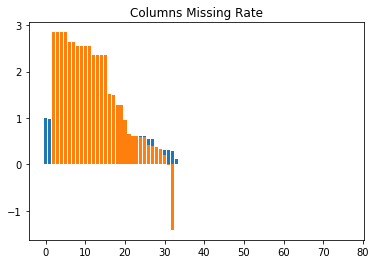

In [17]:
###############################
####  5，在测试集上进行测试  #####
###############################
#准备测试样本#
del test_data['ID']
##############################
####  2，缺失值分析与补缺  #####
##############################
#先检查是否有常数型字段

all_columns = list(test_data.columns)
all_columns.remove('flag')

fix_value_check = {col: len(set(test_data[col])) for col in all_columns}
fix_value_vars = [var for var in list(fix_value_check.keys()) if fix_value_check[var] == 1]
for var in fix_value_vars:
    print("{} is a constant".format(var))
    all_columns.remove(var)
    del test_data[var]

#查看每个字段的缺失率
column_missingrate = {col: Missingrate_Column(test_data, col) for col in all_columns}
column_MR_df = pd.DataFrame.from_dict(column_missingrate, orient='index')
column_MR_df.columns = ['missing_rate']
column_MR_df_sorted = column_MR_df.sort_values(by='missing_rate', ascending=False)
plt.bar(x=range(column_MR_df_sorted.shape[0]), height=column_MR_df_sorted.missing_rate)
plt.title('Columns Missing Rate')
#由于变量ip_desc_danger在训练集中全部缺失，故将其删去。
all_columns.remove('ip_desc_danger')
del test_data['ip_desc_danger']
column_MR_df_sorted = column_MR_df_sorted.drop(index=['ip_desc_danger'])
columns_with_missing = column_MR_df_sorted[column_MR_df_sorted.missing_rate > 0].index

#查看缺失值与非缺失值对欺诈的影响
check_missingrate = {}
for col in columns_with_missing:
    temp_df = test_data[[col,'flag']]
    temp_df[col] = temp_df.apply(lambda x: int(x[col] != x[col]),axis=1)
    a = temp_df['flag'].groupby(temp_df[col]).mean()
    check_missingrate[col] = [a.ix[0], a.ix[1]]
check_missingrate_df = pd.DataFrame.from_dict(check_missingrate, orient='index')
check_missingrate_df['log_odds'] = check_missingrate_df.apply(lambda x: np.log(x[1] / x[0]), axis = 1)
check_missingrate_df_sorted = check_missingrate_df.sort_values(by='log_odds', ascending=False)
check_missingrate_df_sorted.columns = ['fraud_rate_nonmissing', 'fraud_rate_missing','log_odds']
plt.bar(x = range(check_missingrate_df_sorted.shape[0]), height = check_missingrate_df_sorted.log_odds)


categorical_cols = []
numerical_cols = []
#区分类别型变量和数值型变量
for col in all_columns:
    temp_df = test_data[test_data[col].notna()][col]
    temp_df = list(set(temp_df))
    if len(temp_df)<=10 or isinstance(temp_df[0],str):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

### 对类别型变量进行哑变量编码，并删除原始变量 ###
dummy_map = {}
dummy_columns = []
for raw_col in categorical_cols:
    dummies = pd.get_dummies(test_data.loc[:, raw_col], prefix=raw_col)
    col_onehot = pd.concat([test_data[raw_col], dummies], axis=1)
    col_onehot = col_onehot.drop_duplicates()
    test_data = pd.concat([test_data, dummies], axis=1)
    del test_data[raw_col]
    dummy_map[raw_col] = col_onehot
    dummy_columns = dummy_columns + list(dummies)


#对于数值型变量，可以将原始变量与表示缺失状态的示性变量交互地使用.此外，由于这些变量都是非负数，对于缺失，可以用0来填补
for col in numerical_cols:
    missing_values = test_data[test_data[col].isna()]
    if missing_values.shape[0]>0:
        test_data[col+'_ismissing']  = test_data[col].map(lambda x: int(x!=x))

test_data = test_data.fillna(0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
test_data['age_ismissing']  = test_data['age'].map(lambda x: int(x==0))

In [18]:
X_test = test_data.copy()
X_test = X_test[df_sorted['features'][:20]]
# del X_test['flag']
x_test = np.matrix(X_test)
y_test = np.matrix(test_data['flag']).T
clf_pred_proba = clf1.predict_proba(x_test)
pred_proba = [i[1] for i in clf_pred_proba]
auc_score = roc_auc_score(y_test.getA(),pred_proba)    #0.995
auc_score

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ian\AppData\Local\Temp\tmpj4x2rl8d\model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.5

### end

### end

### end

### end

### end

In [19]:
### end

### end

### end